# Time Series Analysis — AutoRegression (AR) Model
## RELIANCE.NS | 2005 | With Stationarity Phase

**Pipeline:**
1. Data Collection (yfinance)
2. **Stationarity Testing (ADF Test)**
3. **Differencing + ACF/PACF Analysis**
4. Normalization (MinMaxScaler on stationary data)
5. Train/Test Split
6. AR Model Grid Search
7. Best Model Evaluation
8. Inverse Transform → Original Price Scale
9. Forecasting

---
## Step 1: Install & Import Libraries

In [1]:
!pip install yfinance statsmodels scikit-learn matplotlib --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Step 2: Download Stock Data

In [3]:
ticker = "RELIANCE.NS"
year = 2005
start_date = f"{year}-01-01"
end_date   = f"{year}-12-31"

stk_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if stk_data.empty:
    print(f"No data available for {ticker} in {year}.")
else:
    stk_data = stk_data[["Open", "High", "Low", "Close"]]
    print(f"OHLC data for {ticker} in {year}:")
    print(stk_data.head())
    print(f"\nShape: {stk_data.shape}")

OHLC data for RELIANCE.NS in 2005:
Price             Open        High         Low       Close
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                      
2005-01-03   32.366297   32.702323   32.030272   32.633316
2005-01-04   33.002335   33.002335   31.778249   31.877256
2005-01-05   31.562243   32.009274   30.971201   31.799257
2005-01-06   31.682242   32.192278   31.337215   31.574236
2005-01-07   32.102282   32.864335   31.655251   32.537312

Shape: (250, 4)


In [4]:
column = "Close"
close_prices = stk_data[[column]].copy()
close_prices.head()

Price,Close
Ticker,RELIANCE.NS
Date,
2005-01-03,32.633316
2005-01-04,31.877256
2005-01-05,31.799257
2005-01-06,31.574236
2005-01-07,32.537312


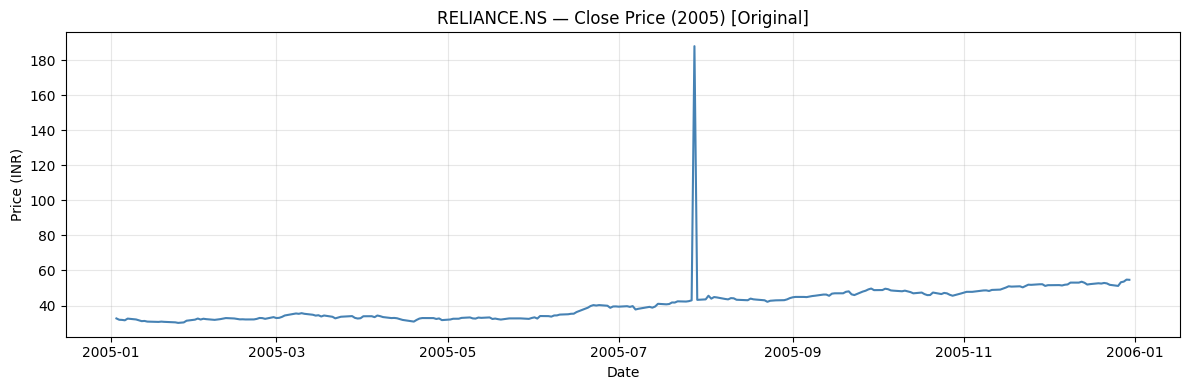

In [5]:
# Visualize raw Close price
plt.figure(figsize=(12, 4))
plt.plot(close_prices, color='steelblue', linewidth=1.5)
plt.title(f"{ticker} — Close Price ({year}) [Original]")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## ⚡ Step 3: Stationarity Phase

### Why Stationarity Matters?
AR models assume the time series is **stationary** — meaning:
- Constant mean over time
- Constant variance over time
- No systematic trend or seasonality

Non-stationary data causes **spurious regression** — the model fits noise rather than real patterns.

### Test: Augmented Dickey-Fuller (ADF)
- **H₀ (Null):** Series has a unit root → **Non-stationary**
- **H₁ (Alt):** Series is **stationary**
- **Rule:** If p-value < 0.05 → Reject H₀ → Series is **Stationary** ✅

In [6]:
def adf_test(series, series_name="Series"):
    """
    Performs Augmented Dickey-Fuller test and prints a clean report.
    Returns True if stationary, False otherwise.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    adf_stat   = result[0]
    p_value    = result[1]
    used_lags  = result[2]
    n_obs      = result[3]
    crit_vals  = result[4]
    
    print("="*55)
    print(f"  ADF Stationarity Test — {series_name}")
    print("="*55)
    print(f"  ADF Statistic  : {adf_stat:.6f}")
    print(f"  p-value        : {p_value:.6f}")
    print(f"  Lags Used      : {used_lags}")
    print(f"  Observations   : {n_obs}")
    print("  Critical Values:")
    for key, val in crit_vals.items():
        marker = "<-- ADF" if adf_stat < val else ""
        print(f"    {key}: {val:.4f}  {marker}")
    print("-"*55)
    
    if p_value < 0.05:
        print(f"  ✅ RESULT: STATIONARY  (p={p_value:.4f} < 0.05)")
        stationary = True
    else:
        print(f"  ❌ RESULT: NON-STATIONARY  (p={p_value:.4f} ≥ 0.05)")
        print(f"     → Differencing required!")
        stationary = False
    print("="*55)
    return stationary

In [7]:
# ---- ADF Test on Original Close Price ----
is_stationary = adf_test(close_prices[column], series_name="Close Price (Original)")

  ADF Stationarity Test — Close Price (Original)
  ADF Statistic  : -2.231291
  p-value        : 0.195085
  Lags Used      : 6
  Observations   : 243
  Critical Values:
    1%: -3.4576  
    5%: -2.8735  
    10%: -2.5731  
-------------------------------------------------------
  ❌ RESULT: NON-STATIONARY  (p=0.1951 ≥ 0.05)
     → Differencing required!


### Step 3.2: Apply First-Order Differencing

**Formula:** `y'(t) = y(t) - y(t-1)`

Differencing removes trend by computing day-over-day price change.  
The first row becomes NaN (no prior value) — we drop it.

In [9]:
close_diff = close_prices[column].diff().dropna()

print(f"Original series length   : {len(close_prices)}")
print(f"Differenced series length: {len(close_diff)}")
print(f"\nFirst 5 differenced values:\n{close_diff.head()}")
print(f"\nMean of differenced series : {float(close_diff.mean()):.4f}")
print(f"Std  of differenced series : {float(close_diff.std()):.4f}")

Original series length   : 250
Differenced series length: 249

First 5 differenced values:
Ticker      RELIANCE.NS
Date                   
2005-01-04    -0.756060
2005-01-05    -0.077999
2005-01-06    -0.225021
2005-01-07     0.963076
2005-01-10    -0.486034

Mean of differenced series : 0.0885
Std  of differenced series : 13.0234


In [10]:
# ---- ADF Test on Differenced Series ----
is_stationary_diff = adf_test(close_diff, series_name="Close Price (1st Order Differenced)")

  ADF Stationarity Test — Close Price (1st Order Differenced)
  ADF Statistic  : -9.054552
  p-value        : 0.000000
  Lags Used      : 7
  Observations   : 241
  Critical Values:
    1%: -3.4578  <-- ADF
    5%: -2.8736  <-- ADF
    10%: -2.5732  <-- ADF
-------------------------------------------------------
  ✅ RESULT: STATIONARY  (p=0.0000 < 0.05)


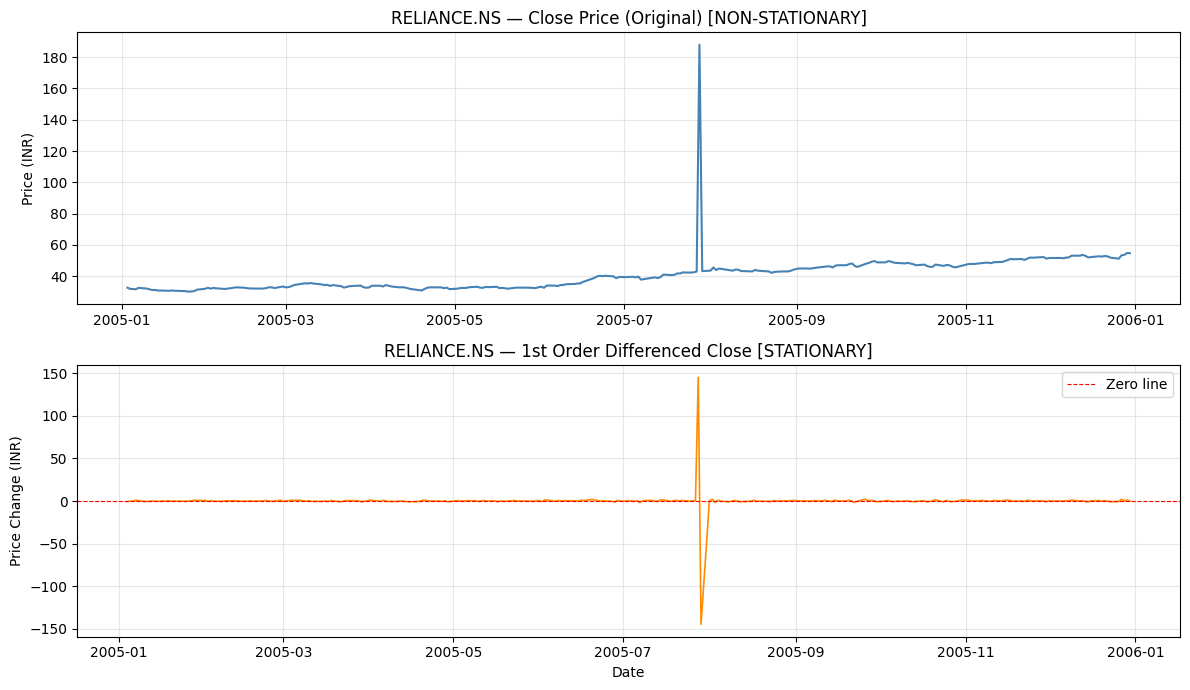

In [11]:
# Visualize: Original vs Differenced
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

axes[0].plot(close_prices[column], color='steelblue', linewidth=1.5)
axes[0].set_title(f"{ticker} — Close Price (Original) [NON-STATIONARY]", fontsize=12)
axes[0].set_ylabel("Price (INR)")
axes[0].grid(alpha=0.3)

axes[1].plot(close_diff, color='darkorange', linewidth=1.2)
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero line')
axes[1].set_title(f"{ticker} — 1st Order Differenced Close [STATIONARY]", fontsize=12)
axes[1].set_ylabel("Price Change (INR)")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3.3: ACF & PACF Analysis

- **ACF (Autocorrelation Function):** Correlation of series with its lags — helps identify MA order
- **PACF (Partial Autocorrelation Function):** Direct correlation at each lag (removing intermediate) — helps identify **AR order** (number of lags)

**Rule:** For AR model, use the last lag where PACF is significant (outside blue band)

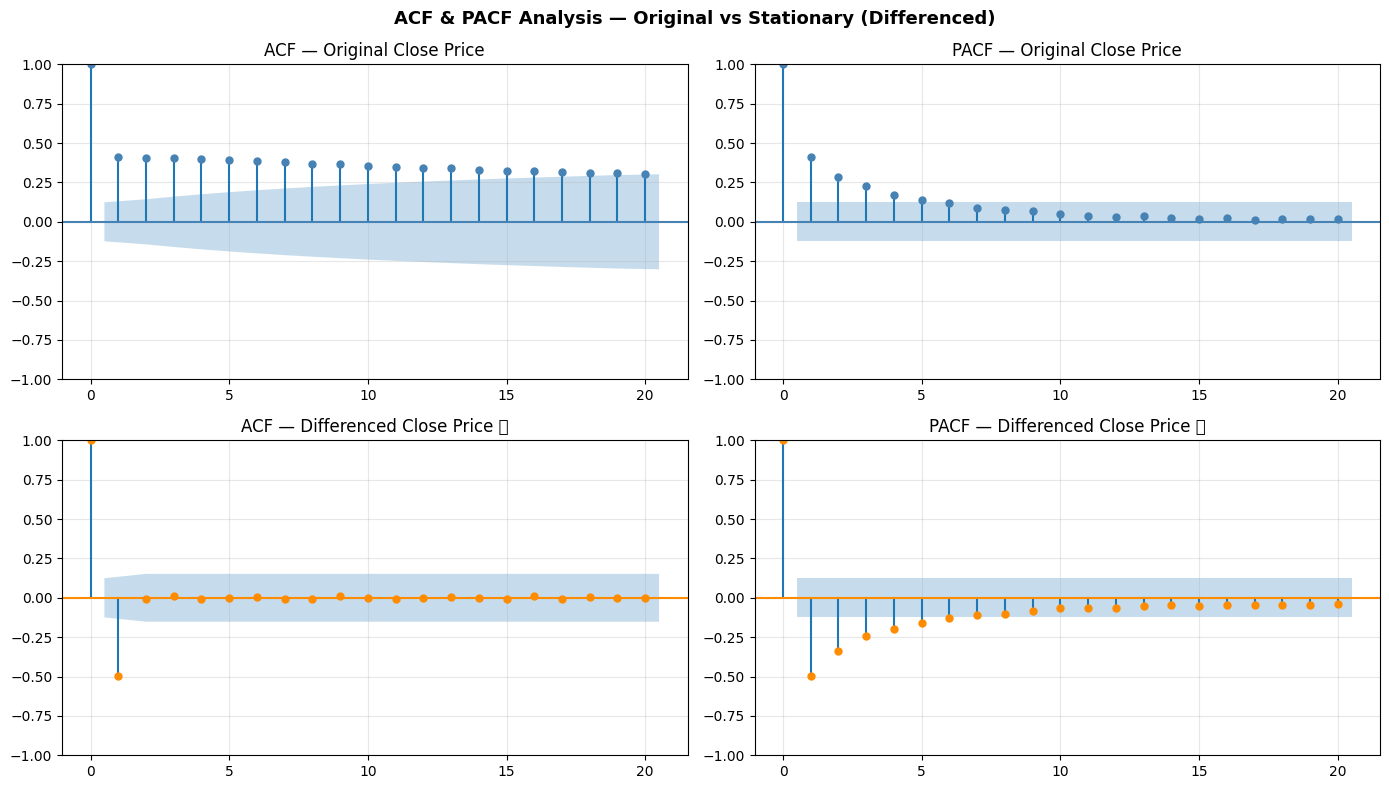


📌 Interpretation:
  - In PACF of Differenced series: significant lags = suggested AR lags
  - ACF cuts off quickly in differenced series → confirms stationarity


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF - Original
plot_acf(close_prices[column], lags=20, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("ACF — Original Close Price")

# PACF - Original
plot_pacf(close_prices[column], lags=20, ax=axes[0, 1], method='ywm', color='steelblue')
axes[0, 1].set_title("PACF — Original Close Price")

# ACF - Differenced
plot_acf(close_diff, lags=20, ax=axes[1, 0], color='darkorange')
axes[1, 0].set_title("ACF — Differenced Close Price ✅")

# PACF - Differenced
plot_pacf(close_diff, lags=20, ax=axes[1, 1], method='ywm', color='darkorange')
axes[1, 1].set_title("PACF — Differenced Close Price ✅")

for ax in axes.flatten():
    ax.grid(alpha=0.3)

plt.suptitle("ACF & PACF Analysis — Original vs Stationary (Differenced)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 Interpretation:")
print("  - In PACF of Differenced series: significant lags = suggested AR lags")
print("  - ACF cuts off quickly in differenced series → confirms stationarity")

---
## Step 4: Normalization (on Stationary/Differenced Data)

In [13]:
# Store last training value for inverse differencing later
# We'll compute this after the train split

Ms = MinMaxScaler()

# Fit and transform differenced series
data1 = Ms.fit_transform(close_diff.values.reshape(-1, 1))

print(f"Differenced + Normalized data shape: {data1.shape}")
print(f"Min value after scaling: {data1.min():.4f}")
print(f"Max value after scaling: {data1.max():.4f}")

Differenced + Normalized data shape: (249, 1)
Min value after scaling: 0.0000
Max value after scaling: 1.0000


---
## Step 5: Train / Test Split (80/20)

In [15]:
training_size = round(len(data1) * 0.80)
print(f"Training size : {training_size}")
print(f"Test size     : {len(data1) - training_size}")

X_train = data1[:training_size]
X_test  = data1[training_size:]
y_train = data1[:training_size]
y_test  = data1[training_size:]

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

last_train_price = float(close_prices[column].iloc[training_size])
print(f"\nLast original close price at train boundary: {last_train_price:.2f} INR")

Training size : 199
Test size     : 50

X_train shape: (199, 1)
X_test shape : (50, 1)

Last original close price at train boundary: 46.51 INR


---
## Step 6: AR Model Grid Search (on Stationary Data)

In [16]:
def rmsemape(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    if label:
        print(f"  [{label}] RMSE: {rmse:.6f} | MAPE: {mape:.6f}")
    return rmse, mape

In [17]:
trends = ['n', 't', 'c', 'ct']
lags   = [1, 2, 3, 4]

results = []

print("Grid Search — AR Model on Stationary (Differenced) Data")
print("="*60)

for i in lags:
    for td in trends:
        model     = AutoReg(X_train, lags=i, trend=td)
        model_fit = model.fit()
        y_pred    = model_fit.predict(start=len(X_train), end=len(data1)-1)
        
        rmse, mape = rmsemape(y_test, y_pred, label=f"Lag={i}, Trend={td}")
        results.append({'lag': i, 'trend': td, 'rmse': rmse, 'mape': mape})

# Find best config
results_df = pd.DataFrame(results).sort_values('rmse')
print("\n" + "="*60)
print("Top 5 Configurations (by RMSE):")
print(results_df.head())

Grid Search — AR Model on Stationary (Differenced) Data
  [Lag=1, Trend=n] RMSE: 0.171888 | MAPE: 0.309041
  [Lag=1, Trend=t] RMSE: 0.246858 | MAPE: 0.451248
  [Lag=1, Trend=c] RMSE: 0.002320 | MAPE: 0.003629
  [Lag=1, Trend=ct] RMSE: 0.002306 | MAPE: 0.003620
  [Lag=2, Trend=n] RMSE: 0.044602 | MAPE: 0.079050
  [Lag=2, Trend=t] RMSE: 0.095802 | MAPE: 0.165874
  [Lag=2, Trend=c] RMSE: 0.002382 | MAPE: 0.003675
  [Lag=2, Trend=ct] RMSE: 0.002375 | MAPE: 0.003680
  [Lag=3, Trend=n] RMSE: 0.016568 | MAPE: 0.029508
  [Lag=3, Trend=t] RMSE: 0.035828 | MAPE: 0.060921
  [Lag=3, Trend=c] RMSE: 0.002357 | MAPE: 0.003648
  [Lag=3, Trend=ct] RMSE: 0.002353 | MAPE: 0.003646
  [Lag=4, Trend=n] RMSE: 0.008794 | MAPE: 0.015692
  [Lag=4, Trend=t] RMSE: 0.015306 | MAPE: 0.025468
  [Lag=4, Trend=c] RMSE: 0.002443 | MAPE: 0.003775
  [Lag=4, Trend=ct] RMSE: 0.002446 | MAPE: 0.003778

Top 5 Configurations (by RMSE):
    lag trend      rmse      mape
3     1    ct  0.002306  0.003620
2     1     c  0.002320

---
## Step 7: Best Model Training & Evaluation

In [18]:
# Best configuration from grid search
best = results_df.iloc[0]
i  = int(best['lag'])
td = best['trend']

print(f"Best Config → Lag={i}, Trend='{td}'")
print(f"  RMSE (normalized): {best['rmse']:.6f}")
print(f"  MAPE (normalized): {best['mape']:.6f}")

# Train best model
model     = AutoReg(X_train, lags=i, trend=td)
model_fit = model.fit()

# Predict on test set
y_pred = model_fit.predict(start=len(X_train), end=len(data1)-1)

Best Config → Lag=1, Trend='ct'
  RMSE (normalized): 0.002306
  MAPE (normalized): 0.003620


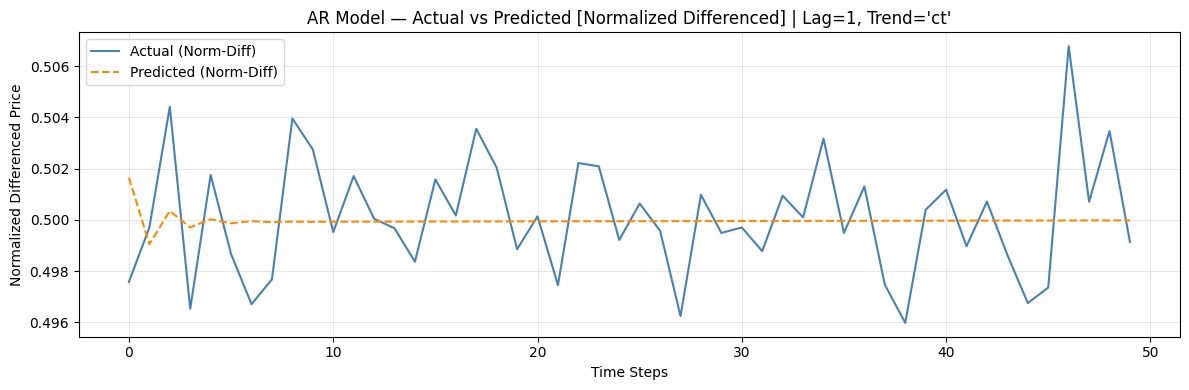

In [19]:
# Plot: Actual vs Predicted (Normalized Differenced Scale)
plt.figure(figsize=(12, 4))
plt.plot(y_test,  label='Actual (Norm-Diff)',    color='steelblue',  linewidth=1.5)
plt.plot(y_pred,  label='Predicted (Norm-Diff)', color='darkorange', linewidth=1.5, linestyle='--')
plt.title(f"AR Model — Actual vs Predicted [Normalized Differenced] | Lag={i}, Trend='{td}'")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Differenced Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## Step 8: Inverse Transform → Original Price Scale

To recover original prices from the differenced + normalized predictions:

1. **De-normalize:** `inverse_transform(y_pred)` → price changes (differenced scale)
2. **Inverse differencing via cumsum:**  
   `reconstructed[0] = last_train_price + diff[0]`  
   `reconstructed[t] = reconstructed[t-1] + diff[t]`

In [20]:
# --- Inverse Transform: Actual Test ---
y_test_arr  = y_test.reshape(-1, 1)
y_test_diff = Ms.inverse_transform(y_test_arr)  # back to price changes (INR diff)

# Cumsum to recover price levels
actual_ori = last_train_price + np.cumsum(y_test_diff.flatten())

# --- Inverse Transform: Predicted ---
y_pred_arr  = np.array(y_pred).reshape(-1, 1)
y_pred_diff = Ms.inverse_transform(y_pred_arr)

predicted_ori = last_train_price + np.cumsum(y_pred_diff.flatten())

print(f"Actual prices (original scale) — first 5 : {actual_ori[:5]}")
print(f"Predicted prices (original scale) — first 5: {predicted_ori[:5]}")

Actual prices (original scale) — first 5 : [45.94259644 45.99485779 47.41192627 46.54508972 47.19060516]
Predicted prices (original scale) — first 5: [47.12067247 46.9840466  47.22296604 47.27526531 47.42118326]


In [21]:
# Metrics on original scale
rmse_ori = np.sqrt(mean_squared_error(actual_ori, predicted_ori))
mape_ori = mean_absolute_percentage_error(actual_ori, predicted_ori)
r2_ori   = r2_score(actual_ori, predicted_ori)

print("="*50)
print(f"  Best Model: Lag={i}, Trend='{td}'")
print("  Metrics on ORIGINAL Price Scale:")
print(f"    RMSE : {rmse_ori:.4f} INR")
print(f"    MAPE : {mape_ori:.4f} ({mape_ori*100:.2f}%)")
print(f"    R²   : {r2_ori:.4f}")
print("="*50)

  Best Model: Lag=1, Trend='ct'
  Metrics on ORIGINAL Price Scale:
    RMSE : 1.2685 INR
    MAPE : 0.0212 (2.12%)
    R²   : 0.7400


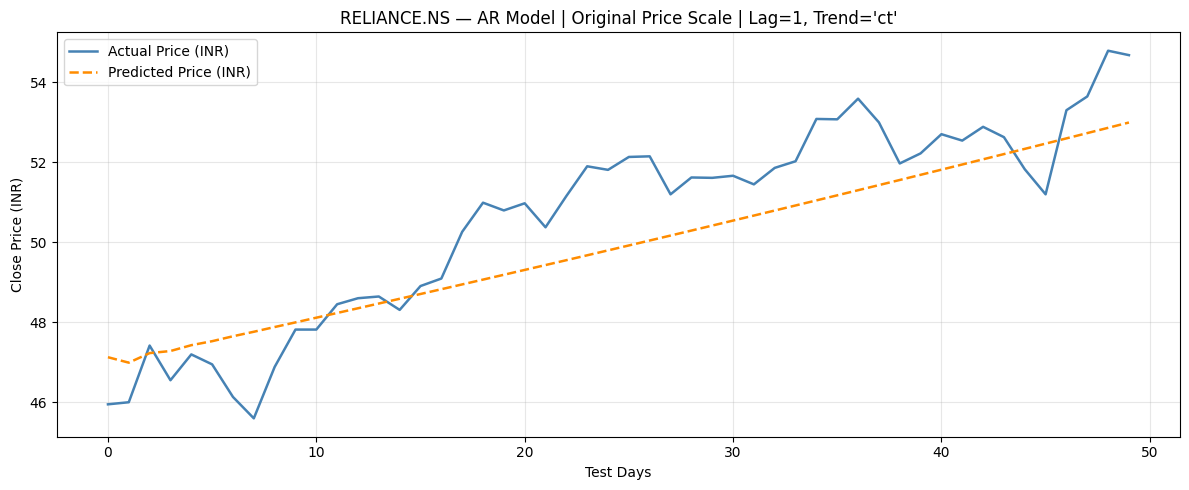

In [22]:
# Plot: Original price scale
plt.figure(figsize=(12, 5))
plt.plot(actual_ori,    label='Actual Price (INR)',    color='steelblue',  linewidth=1.8)
plt.plot(predicted_ori, label='Predicted Price (INR)', color='darkorange', linewidth=1.8, linestyle='--')
plt.title(f"RELIANCE.NS — AR Model | Original Price Scale | Lag={i}, Trend='{td}'")
plt.xlabel("Test Days")
plt.ylabel("Close Price (INR)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## Step 9: Forecasting (4 Steps Ahead)

In [24]:
forecast_norm = model_fit.predict(start=len(data1), end=len(data1)+3)
print("Forecast (normalized differenced):", forecast_norm)

forecast_arr  = np.array(forecast_norm).reshape(-1, 1)
forecast_diff = Ms.inverse_transform(forecast_arr)

last_known_price = float(close_prices[column].iloc[-1])
print(f"Last known original Close price: {last_known_price:.2f} INR")

forecast_ori = last_known_price + np.cumsum(forecast_diff.flatten())

forecast_df = pd.DataFrame({
    'Step': [1, 2, 3, 4],
    'Forecasted_Close_INR': forecast_ori
})
print("\n📈 4-Step Ahead Forecast:")
print(forecast_df)

forecast_df.to_csv("CloseAR.csv", index=False)
print("\nSaved to CloseAR.csv")

Forecast (normalized differenced): [0.49998155 0.49998291 0.49998426 0.49998562]
Last known original Close price: 54.67 INR

📈 4-Step Ahead Forecast:
   Step  Forecasted_Close_INR
0     1             54.805467
1     2             54.938837
2     3             55.072601
3     4             55.206757

Saved to CloseAR.csv


In [26]:
# Inverse transform forecast
forecast_arr  = np.array(forecast_norm).reshape(-1, 1)
forecast_diff = Ms.inverse_transform(forecast_arr)  # price changes

# Base price = last known actual price in dataset
last_known_price = float(close_prices[column].iloc[-1])
print(f"Last known original Close price: {last_known_price:.2f} INR")

# Reconstruct forecast prices
forecast_ori = last_known_price + np.cumsum(forecast_diff.flatten())

forecast_df = pd.DataFrame({
    'Step': [1, 2, 3, 4],
    'Forecasted_Close_INR': forecast_ori
})
print("\n📈 4-Step Ahead Forecast (Original Price Scale):")
print(forecast_df)

Last known original Close price: 54.67 INR

📈 4-Step Ahead Forecast (Original Price Scale):
   Step  Forecasted_Close_INR
0     1             54.805467
1     2             54.938837
2     3             55.072601
3     4             55.206757


In [27]:
# Save forecast to CSV
forecast_df.to_csv("CloseAR.csv", index=False)
print("Forecast saved to CloseAR.csv")

Forecast saved to CloseAR.csv


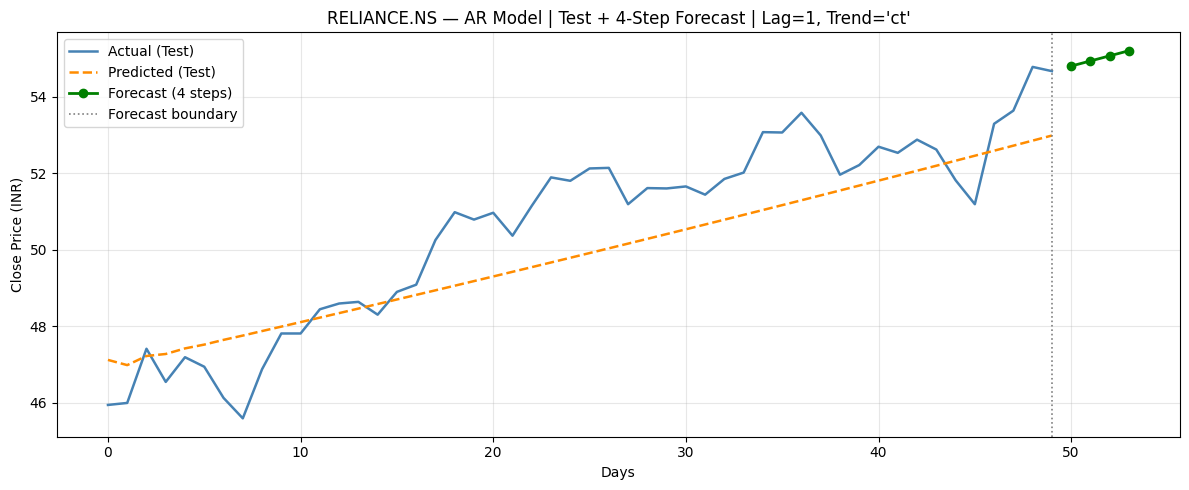

In [28]:
# Final visualization: actual test + forecast
plt.figure(figsize=(12, 5))
plt.plot(range(len(actual_ori)), actual_ori,    label='Actual (Test)',    color='steelblue',  linewidth=1.8)
plt.plot(range(len(actual_ori)), predicted_ori, label='Predicted (Test)', color='darkorange', linewidth=1.8, linestyle='--')
plt.plot(
    range(len(actual_ori), len(actual_ori)+4),
    forecast_ori,
    label='Forecast (4 steps)',
    color='green', linewidth=2, marker='o', markersize=6
)
plt.axvline(len(actual_ori)-1, color='gray', linestyle=':', linewidth=1.2, label='Forecast boundary')
plt.title(f"RELIANCE.NS — AR Model | Test + 4-Step Forecast | Lag={i}, Trend='{td}'")
plt.xlabel("Days")
plt.ylabel("Close Price (INR)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## Summary

| Phase | Action |
|---|---|
| **ADF Test (Original)** | Non-stationary detected (p ≥ 0.05) |
| **1st Order Differencing** | `y'(t) = y(t) - y(t-1)` |
| **ADF Test (Differenced)** | Stationary confirmed (p < 0.05) ✅ |
| **ACF/PACF** | Lag selection for AR model |
| **Normalization** | MinMaxScaler on stationary data |
| **AR Grid Search** | Lags [1-4] × Trends ['n','t','c','ct'] |
| **Inverse Transform** | De-normalize → cumsum → original price |
| **Forecast** | 4 steps ahead on original INR scale |